In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np

In [13]:
def getUniqueModels(allModels):
    ##MUST PASS IN MODEL ENTITY
    ##GETS BEST MODEL FOR EACH INPUT SERIES
    sequences = {} 
    for modelEntity in allModels:
        model = modelEntity["model"]
        thisSeq = str(model.inputSeries.windowSize) + "," + \
                      str(model.inputSeries.series.describe())
        if thisSeq not in sequences:
            sequences[thisSeq] = []
        sequences[thisSeq].append({
            "model":model,
            "info":modelEntity
        })
    modelsToReturn = []
    for seq in sequences:
        bestModel = None
        for modelInfo in sequences[seq]:
            if bestModel is None:
                bestModel = modelInfo
            else:
                if bestModel["info"]["STABILITY"] < modelInfo["info"]["STABILITY"]:
                    bestModel = modelInfo
        modelsToReturn.append(bestModel["model"])
    return modelsToReturn

In [14]:
import portfolio
import dataAck
import warnings
import numpy as np
warnings.filterwarnings("ignore")
tickerToTrade = "EWZ"
allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
for modelEntity in allModels:
    model = modelEntity["model"]
    print(model.describe())

((22, ('GDX', 32, None, None), 2, 'EWZ'), 22, 50)
((22, ('GDX', 32, None, None), 5, 'EWZ'), 22, 50)
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 25)
((22, ('GDX', 32, None, None), 2, 'EWZ'), 22, 250)
((10, ('GDX', 32, None, None), 5, 'EWZ'), 10, 25)
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
((10, ('GDX', 32, None, None), 2, 'EWZ'), 10, 100)
((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 250)
((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)


In [15]:
uniqueModels = getUniqueModels(allModels)
for model in uniqueModels:
    print(model.describe())

((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)


# VIEW CORRELATION AND COVARIANCE

In [16]:
def generateAllReturns(allModels, joinedData):
    aggregateReturns = None
    aggregatePredictions = None
    for mod in allModels:
        print(mod.describe())
        algoReturn, factorReturn, predictions =  mod.makePredictions(joinedData)
        algoReturn.columns = [str(mod.describe())]
        predictions.columns = [str(mod.describe())]
        if aggregateReturns is None:
            aggregateReturns = algoReturn
            aggregatePredictions = predictions
        else:
            aggregateReturns = aggregateReturns.join(algoReturn)
            aggregatePredictions = aggregatePredictions.join(predictions)
    return aggregateReturns, aggregatePredictions

In [17]:
tickersRequired = []
tickersTraded = []
for mod in uniqueModels:
    
    print(mod.describe())
    if mod.inputSeries.targetTicker not in tickersRequired:
        tickersRequired.append(mod.inputSeries.targetTicker)
    if mod.inputSeries.series.ticker not in tickersRequired:
        tickersRequired.append(mod.inputSeries.series.ticker)
    if mod.inputSeries.targetTicker not in tickersTraded:
        tickersTraded.append(mod.inputSeries.targetTicker)
    

pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
modelReturns, modelPredictions = generateAllReturns(uniqueModels, joinedData)

((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)
GDX
EWZ
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
THREAD  0 PROGRESS: 0.8333333333333334
THREAD  1 PROGRESS: 0.8333333333333334
THREAD  2 PROGRESS: 0.8333333333333334
THREAD  3 PROGRESS: 0.8333333333333334
THREAD  5 PROGRESS: 0.8333333333333334
THREAD  7 PROGRESS: 0.8333333333333334
THREAD  4 PROGRESS: 0.8333333333333334
THREAD  8 PROGRESS: 0.8333333333333334
THREAD  12 PROGRESS: 0.8333333333333334
THREAD  6 PROGRESS: 0.8333333333333334
THREAD  11 PROGRESS: 0.8333333333333334
THREAD  9 PROGRESS: 0.8333333333333334
THREAD  10 PROGRESS: 0.8333333333333334
THREAD  13 PROGRESS: 0.8333333333333334
THREAD  14 PROGRESS: 0.8333333333333334
THREAD  15 PROGRESS: 0.8333333333333334
THREAD  17 PROGRESS: 0.8333333333333334
THREAD  21 PROGRESS: 0.8333333333333334
THREAD  25 PROGRESS: 0.8333333333333334
THREAD  16 PROGRESS: 0.8333333333333334
THREAD  18 PROGRESS: 0.8333333333333334
THREAD  20

In [18]:
modelReturns

,"((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)","((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)"
2009-03-02,0.003404,0.013616
2009-03-03,0.000000,0.035261
2009-03-04,-0.006623,-0.013245
2009-03-05,-0.001074,-0.000000
2009-03-06,-0.006638,-0.000000
2009-03-09,0.078182,0.000000
2009-03-10,-0.002361,-0.000000
2009-03-11,0.032116,0.016058
2009-03-12,-0.006223,-0.000000
2009-03-13,-0.007910,-0.000000


In [19]:
modelPredictions

,"((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)","((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)"
2009-03-02,0.25,1.00
2009-03-03,0.00,0.50
2009-03-04,0.25,0.50
2009-03-05,0.50,0.00
2009-03-06,0.50,0.00
2009-03-09,1.00,0.00
2009-03-10,1.00,0.00
2009-03-11,1.00,0.50
2009-03-12,1.00,0.00
2009-03-13,1.00,0.00


In [20]:
modelReturnsWithFactor = modelReturns.join(dataAck.getDailyFactorReturn(tickerToTrade, joinedData))

In [21]:
def visualizeModels(modelReturns):
    from string import ascii_letters
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from IPython.display import display

    sns.set(style="white")


    # Compute the correlation matrix
    corr = modelReturns.corr()
    display(corr)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    from matplotlib.colors import ListedColormap

    # construct cmap
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    cmap = ListedColormap(sns.color_palette(flatui).as_hex())
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
    sns.set(style="white")
    
    # Compute the covariance matrix
    cov = modelReturns.cov()
    display(cov)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(cov, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    cmap = ListedColormap(sns.color_palette(flatui).as_hex())

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(cov, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

,"((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)","((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)",Factor Return
"((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)",1.000000,0.439035,0.224107
"((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)",0.439035,1.000000,0.321504
Factor Return,0.224107,0.321504,1.000000


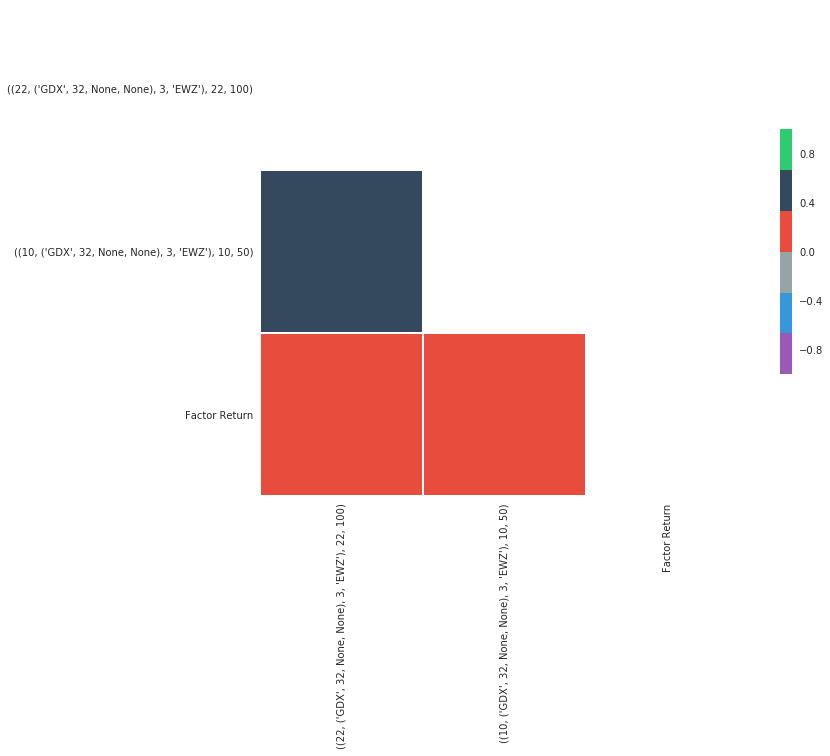

,"((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)","((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)",Factor Return
"((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)",0.000211,0.000084,0.000066
"((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)",0.000084,0.000175,0.000086
Factor Return,0.000066,0.000086,0.000412


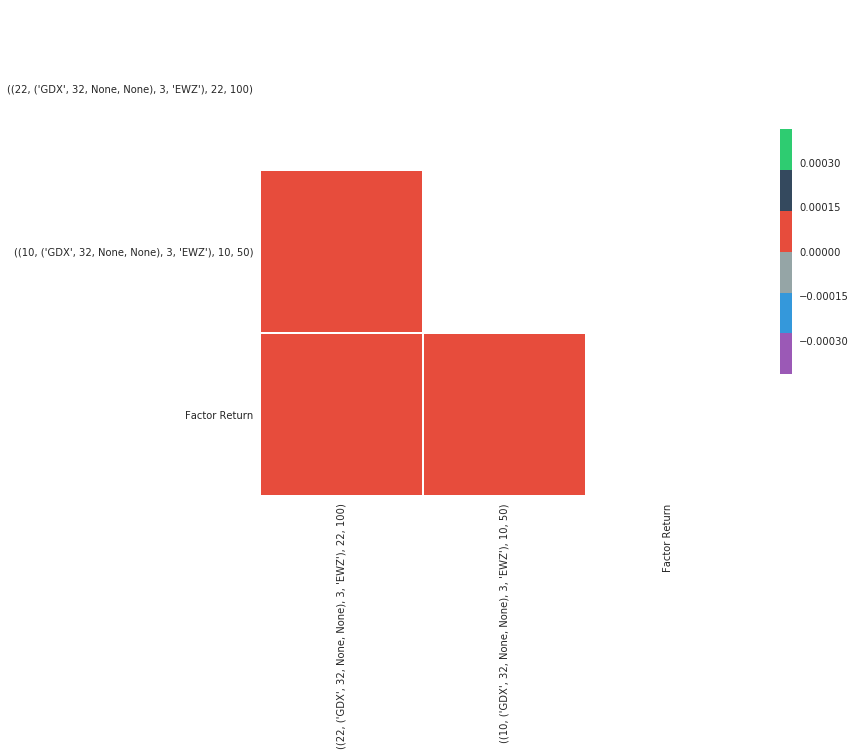

In [22]:
%matplotlib inline
visualizeModels(modelReturnsWithFactor)

# STORE PAST MODEL PREDICTIONS

In [23]:
def storePastPredictions(allModels, modelPredictions):
    ##THESE ARE SUMMED PREDICTIONS...DIFFERENT THAN PREDICTIONS MADE DAILY
    lastDayUsedPredictions = modelPredictions.dropna()
    for i in range(len(lastDayUsedPredictions.columns)):
        thisModel = allModels[i]
        print(thisModel.describe())
        thisDF = lastDayUsedPredictions[[lastDayUsedPredictions.columns[i]]]
        predictionsToStore = []
        for j in range(len(thisDF.values)):
#             print(thisDF.index[i], thisDF.values[i][0])
            predictionsToStore.append(portfolio.storeAggregateModelPrediction(thisModel, thisDF.values[j][0], thisDF.index[j], shouldReturn=True))
        portfolio.storeManyItems(predictionsToStore)
            

In [24]:
storePastPredictions(uniqueModels, modelPredictions)

((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)


# STORE MODELS AS PORTFOLIO

In [25]:
def storePortfolio(models, description, benchmark):
    allHashes = []
    for model in models:
        organismHash = hashlib.sha224(str(model.describe()).encode('utf-8')).hexdigest()
        allHashes.append(organismHash)
    
    allHashes.sort()
    portfolioHash = hashlib.sha224(str(allHashes).encode('utf-8')).hexdigest()
    print("PORTFOLIO HASH:", portfolioHash)
    for hashing in allHashes:
        print(hashing)
        
    
        ##UPLOAD ORGANISM OBJECT
        while True:
            try:
                toUpload = {
                    "portfolio":portfolioHash,
                    "model":hashing
                }
                datastoreClient = datastore.Client('money-maker-1236')
                #HASH DIGEST
                key = datastoreClient.key(params.portfolioDB, hashlib.sha224(str(hashing + portfolioHash).encode('utf-8')).hexdigest()) #NEED TO HASH TO ENSURE UNDER COUNT
                organismToStore = datastore.Entity(key=key)
                organismToStore.update(toUpload)
                datastoreClient.put(organismToStore)
                break
            except:
                print("UPLOAD ERROR:", str(sys.exc_info()))
                time.sleep(10)
    
    ##STORE PORTFOLIO OBJECT
    while True:
        try:
            toUpload = {
                "description":description,
                "benchmark":benchmark
            }
            datastoreClient = datastore.Client('money-maker-1236')
            #HASH DIGEST
            key = datastoreClient.key(params.portfolioLookup, portfolioHash) #NEED TO HASH TO ENSURE UNDER COUNT
            organismToStore = datastore.Entity(key=key)
            organismToStore.update(toUpload)
            datastoreClient.put(organismToStore)
            break
        except:
            print("UPLOAD ERROR:", str(sys.exc_info()))
            time.sleep(10)

In [26]:
storePortfolio(uniqueModels, description="Just trade underlying", benchmark=tickerToTrade)

PORTFOLIO HASH: 5522786eb28943c781c8bf62503848a2bdf51ba50e612fd13c5a3f9f
bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e
e1111d514a667ab22d8f48a2734a7dab0be1350f8ce70ca3b8a172ac


In [27]:
def getPortfolios():
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=params.portfolioLookup)
            retrievedPortfolios = [{
                "key":item.key.name,
                "description":item["description"],
                "benchmark":item["benchmark"]
            } for item in list(query.fetch())]

            return retrievedPortfolios
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))

In [28]:
portfolios = getPortfolios()
print(portfolios)

[{'key': '5522786eb28943c781c8bf62503848a2bdf51ba50e612fd13c5a3f9f', 'description': 'Just trade underlying', 'benchmark': 'EWZ'}, {'key': '7d372f0c7053ce8035616e2ba82f33de0cfebccbd78e4e3798f0c18f', 'description': 'VO 8-13-17', 'benchmark': 'VO'}]


In [29]:
def getPortfolioModels(portfolioKey):
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=params.portfolioDB)
            query.add_filter('portfolio', '=', portfolioKey)
            
            retrievedModels = [item["model"] for item in list(query.fetch())]

            return retrievedModels
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))

In [30]:
for item in portfolios:
    print(item)
    print(getPortfolioModels(item["key"]))

{'key': '5522786eb28943c781c8bf62503848a2bdf51ba50e612fd13c5a3f9f', 'description': 'Just trade underlying', 'benchmark': 'EWZ'}
['e1111d514a667ab22d8f48a2734a7dab0be1350f8ce70ca3b8a172ac', 'bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e']
{'key': '7d372f0c7053ce8035616e2ba82f33de0cfebccbd78e4e3798f0c18f', 'description': 'VO 8-13-17', 'benchmark': 'VO'}
['2c69141675447782e2a74036a7cbd8fb5fc08476cebf557bd6e787a6', '0b84734d97e005d3a2a3a06d82cb793ec1f7557573e3bc032fb7fdf3', '11912f289e86b30f1af1b7272e773732dd099e3069cdf79f1c2ba47e', '78afec28d6c4e55102b09d8b6b179a3508e2b03fb46d2e8858c14fdc', '341fe3e8eb88c9fbdd779c6c8727762f99fc1043383dd8242da044e9']


In [31]:
def getModelsByKey(modelHashes):
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            ##form keys
            keys = []
            for hashing in modelHashes:
                key = datastore_client.key(params.datastoreName, hashing)
                keys.append(key)
                
            retrievedModels = datastore_client.get_multi(keys)
            toReturn = []
            for source in retrievedModels:
                toReturn.append(pickle.loads(source["model"]))
            return toReturn
            
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))

In [32]:
getModelsByKey(getPortfolioModels(item["key"]))